# Analyse des spécificités des genres

Dans ce carnet est proposée une analyse des spécificités des genres, en relation avec le temps et la région d'origine.



In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [328]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql

In [329]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

### Importer les données à analyser

In [330]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/astronomers_import.db')
cn

In [331]:
qr = """
SELECT wp.personUri, wp.personLabel, 
 CASE 
       WHEN wp.genderUri = 	'http://www.wikidata.org/entity/Q6581097'
       THEN 'M'
       WHEN wp.genderUri = 	'http://www.wikidata.org/entity/Q6581072'
       THEN 'F'
       ELSE 'A'
   END AS gender, max(wp.birthYear) AS birthYear,
   max(ga.label) AS area_label
FROM wdt_personne wp 
   JOIN wdt_person_citizenship wpc
	 ON wpc.personUri = wp.personUri
   JOIN wdt_country wc 
     ON wc.wdt_uri = wpc.nationaliteUri 
   JOIN geographic_area ga
     ON ga.pk_geographic_area = wc.fk_geographic_area
     GROUP BY wp.personUri, personLabel
"""

In [332]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()
print(len(l))
l[:3]

23459


[('http://www.wikidata.org/entity/Q1000193',
  'Hans Elsässer',
  'M',
  '1929',
  'Espace_germanique'),
 ('http://www.wikidata.org/entity/Q1000934',
  'Charles Christian Lauritsen',
  'M',
  '1892',
  'Amérique_nord'),
 ('http://www.wikidata.org/entity/Q100153910',
  'Frank J. Blatt',
  'M',
  '1924',
  'Espace_germanique')]

In [333]:
### Créer un DataFrame contenant les données
df_orig = pd.DataFrame(l, columns=['uri', 'nom', 'gender', 'annee_nais', 
                     'origines_geog'])
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23459 entries, 0 to 23458
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   uri            23459 non-null  object
 1   nom            23459 non-null  object
 2   gender         23459 non-null  object
 3   annee_nais     23459 non-null  object
 4   origines_geog  23459 non-null  object
dtypes: object(5)
memory usage: 916.5+ KB


In [334]:
### Distribution des genres
df_orig.groupby(by='gender').size().sort_values(ascending=False)

gender
M    21392
F     2055
A       12
dtype: int64

### Codage par périodes de cinquante ans

In [335]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_orig['annee_nais'] = df_orig['annee_nais'].astype(int)

In [336]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_orig[df_orig['annee_nais'] < 1981].copy(deep=True)
cdf_p.head(3)

,uri,nom,gender,annee_nais,origines_geog
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,M,1929,Espace_germanique
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,M,1892,Amérique_nord
2,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,M,1924,Espace_germanique


In [337]:
### Année minimale et maximale dans la population
min(cdf_p['annee_nais']), max(cdf_p['annee_nais'])

(1360, 1980)

In [338]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_50 = list(range(1351, 2002, 50))
l_50[:5],l_50[-5:]

([1351, 1401, 1451, 1501, 1551], [1801, 1851, 1901, 1951, 2001])

In [339]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_nais'], l_50, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,uri,nom,gender,annee_nais,origines_geog,periodes
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,M,1929,Espace_germanique,1901-1950
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,M,1892,Amérique_nord,1851-1900
2,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,M,1924,Espace_germanique,1901-1950


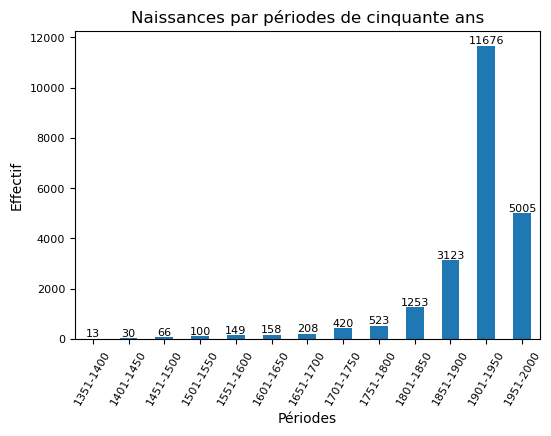

In [340]:
ax = cdf_p.groupby(by='periodes', observed=True).size()\
      .plot(kind='bar',rot=60, fontsize=8, figsize=(6,4))

ax.bar_label(ax.containers[0], fontsize=8)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de cinquante ans')
plt.show()

### Distributions des genres par périodes

In [341]:
### Tableau de contingence
X = "periodes"  # "0"
Y = "gender"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

periodes,1351-1400,1401-1450,1451-1500,1501-1550,1551-1600,1601-1650,1651-1700,1701-1750,1751-1800,1801-1850,1851-1900,1901-1950,1951-2000,Total
gender,,,,,,,,,,,,,,
A,0,0,0,0,0,0,0,0,0,0,0,2,6,8
F,0,1,0,0,2,3,6,10,10,24,208,820,793,1877
M,13,29,66,100,147,155,202,410,513,1229,2915,10854,4206,20839
Total,13,30,66,100,149,158,208,420,523,1253,3123,11676,5005,22724


#### Commentaire

Le tableau de contingence montre que une analyse quantitative est possible seulement à partir de 1851 et à l'exclusion du genre A='autres'. Aussi on limitera les naissances aux personnes nées avant 1976 afin de disposer de périodes de 25 ans complètes

In [342]:
### Création d'un tableau de données pour la période contemporaine 
cdf_cont = cdf_p[(cdf_p.annee_nais > 1851) \
                 & (cdf_p.annee_nais < 1976) \
                 & (cdf_p.gender != 'A')].copy(deep=True)
cdf_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19353 entries, 0 to 23458
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   uri            19353 non-null  object  
 1   nom            19353 non-null  object  
 2   gender         19353 non-null  object  
 3   annee_nais     19353 non-null  int64   
 4   origines_geog  19353 non-null  object  
 5   periodes       19353 non-null  category
dtypes: category(1), int64(1), object(4)
memory usage: 926.7+ KB


In [343]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1851, 1977, 25))
l_25[:5],l_25[-5:]

([1851, 1876, 1901, 1926, 1951], [1876, 1901, 1926, 1951, 1976])

In [344]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_cont['period_25'] = pd.cut(cdf_cont['annee_nais'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_cont['period_25'] = cdf_cont['period_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_cont.head(3)

,uri,nom,gender,annee_nais,origines_geog,periodes,period_25
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,M,1929,Espace_germanique,1901-1950,1926-1950
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,M,1892,Amérique_nord,1851-1900,1876-1900
2,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,M,1924,Espace_germanique,1901-1950,1901-1925


In [345]:
### Tableau de contingence
X = "period_25"  # "0"
Y = "gender"

ddf = cdf_cont[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

period_25,1851-1875,1876-1900,1901-1925,1926-1950,1951-1975,Total
gender,,,,,,
F,53,152,294,526,685,1710
M,1154,1723,3736,7118,3912,17643
Total,1207,1875,4030,7644,4597,19353


In [346]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

period_25,1851-1875,1876-1900,1901-1925,1926-1950,1951-1975
gender,,,,,
F,53,152,294,526,685
M,1154,1723,3736,7118,3912


In [347]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 5 ), effectif: 19353 , nombre max. facteurs: 1


In [348]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 288.9077850587688 , dof : 4
p-value : 2.6742187719147277e-61
phi2 = inertie (variance totale) : 0.014928320418476144
Cramer:  0.1221815060411196


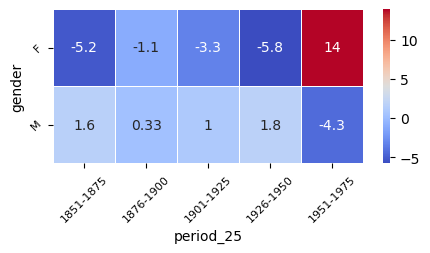

In [349]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(5,2))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=45, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=45, fontsize=8)

plt.show()


#### Commentaire

On observe une progression mais aussi une fluctuation avant 1951, puis un changement d'orientation qui sera à confirmer lorsque les données de la prochaine génération seront disponibles, ce qui n'est pas encore le cas.


Comme la variable 'gender' a deux modalités un seul facteur résumé la variance et une analyse factorielle n'est pas utile.

### Distributions des genres par origines

In [350]:
### Tableau de contingence
X = "gender"
Y = "origines_geog"

ddf = cdf_cont[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

gender,F,M,Total
origines_geog,,,
Afrique_subsaharienne,7,41,48
Amérique_latine,91,329,420
Amérique_nord,389,3322,3711
Asie_méridionale_Inde,63,554,617
Asie_orientale_Chine,56,1083,1139
Balkans,35,228,263
Espace_germanique,180,2869,3049
Europe_centrale,183,1964,2147
Europe_méridionale,161,1279,1440


Si cette table de contingence concerne l'ensemble de la population, on utilise pour la suite la même population que pour l'analyse précédente, limitée donc dans le temps et sans le genre 'A'.

In [351]:
### Tableau de contingence
X = "gender"
Y = "origines_geog"

ddf = cdf_cont[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

gender,F,M,Total
origines_geog,,,
Afrique_subsaharienne,7,41,48
Amérique_latine,91,329,420
Amérique_nord,389,3322,3711
Asie_méridionale_Inde,63,554,617
Asie_orientale_Chine,56,1083,1139
Balkans,35,228,263
Espace_germanique,180,2869,3049
Europe_centrale,183,1964,2147
Europe_méridionale,161,1279,1440


In [352]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

gender,F,M
origines_geog,,
Afrique_subsaharienne,7,41
Amérique_latine,91,329
Amérique_nord,389,3322
Asie_méridionale_Inde,63,554
Asie_orientale_Chine,56,1083
Balkans,35,228
Espace_germanique,180,2869
Europe_centrale,183,1964
Europe_méridionale,161,1279


In [353]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 14 , 2 ), effectif: 19353 , nombre max. facteurs: 1


In [354]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 214.03103881899477 , dof : 13
p-value : 1.7749063811497727e-38
phi2 = inertie (variance totale) : 0.011059320974473971
Cramer:  0.10516330621692137


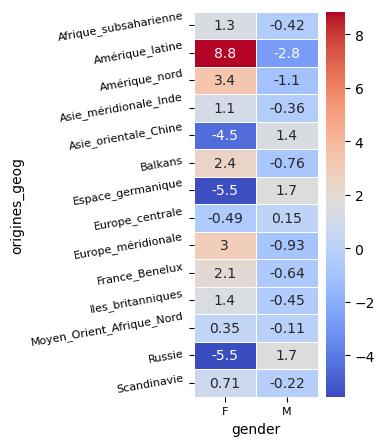

In [355]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(2,5))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, 
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=0, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=10, fontsize=8)



plt.show()


### Commentaire

On observe une présence plus importante des femmes dans les pays qu'on pourrait globalement dire 'latins' ou méridionaux, avec l'exception de l'Amérique du nord

## Analyser le lien entre genre+période et l'aire géographique

Cette analyse plus fine permet de comparer trois variable mais dans une logique bivariée

In [388]:
cdf_cont.period_25 = cdf_cont.period_25.astype("str")
cdf_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19353 entries, 0 to 23458
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   uri               19353 non-null  object  
 1   nom               19353 non-null  object  
 2   gender            19353 non-null  object  
 3   annee_nais        19353 non-null  int64   
 4   origines_geog     19353 non-null  object  
 5   periodes          19353 non-null  category
 6   period_25         19353 non-null  object  
 7   gender_period_25  19353 non-null  object  
dtypes: category(1), int64(1), object(6)
memory usage: 1.2+ MB


In [389]:
cdf_cont['gender_period_25'] = cdf_cont.apply(lambda x: \
                    x.period_25 + '_' + x.gender, axis=1)
cdf_cont.head()

,uri,nom,gender,annee_nais,origines_geog,periodes,period_25,gender_period_25
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,M,1929,Espace_germanique,1901-1950,1926-1950,1926-1950_M
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,M,1892,Amérique_nord,1851-1900,1876-1900,1876-1900_M
2,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,M,1924,Espace_germanique,1901-1950,1901-1925,1901-1925_M
3,http://www.wikidata.org/entity/Q100157315,Ding Jing,M,1924,Asie_orientale_Chine,1901-1950,1901-1925,1901-1925_M
4,http://www.wikidata.org/entity/Q100212,Peter Kramer,M,1933,Espace_germanique,1901-1950,1926-1950,1926-1950_M


In [390]:
cdf_cont.groupby(by='gender_period_25').size()


gender_period_25
1851-1875_F      53
1851-1875_M    1154
1876-1900_F     152
1876-1900_M    1723
1901-1925_F     294
1901-1925_M    3736
1926-1950_F     526
1926-1950_M    7118
1951-1975_F     685
1951-1975_M    3912
dtype: int64

In [391]:
### Tableau de contingence
X = "gender_period_25"
Y = "origines_geog"

ddf = cdf_cont[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

gender_period_25,1851-1875_F,1851-1875_M,1876-1900_F,1876-1900_M,1901-1925_F,1901-1925_M,1926-1950_F,1926-1950_M,1951-1975_F,1951-1975_M,Total
origines_geog,,,,,,,,,,,
Afrique_subsaharienne,0,5,0,5,3,11,0,16,4,4,48
Amérique_latine,0,14,0,20,11,61,34,149,46,85,420
Amérique_nord,20,161,45,268,74,914,115,1387,135,592,3711
Asie_méridionale_Inde,2,23,1,35,10,103,18,258,32,135,617
Asie_orientale_Chine,0,20,0,59,14,248,18,461,24,295,1139
Balkans,0,3,0,4,2,15,15,102,18,104,263
Espace_germanique,3,278,29,447,33,545,34,1021,81,578,3049
Europe_centrale,3,73,12,169,27,311,90,887,51,524,2147
Europe_méridionale,0,105,9,117,21,179,34,414,97,464,1440


NB : comme les Balkans, l'Afrique subsaharienne et le Moyen_Orient_Afrique_Nord ont des effectifs limités ils risquent de biaiser l'analyse. Nous ne les ajoutons pas aux données à analyser.

In [394]:
### Liste construite manuellement à partir de cette liste
# print(ddf.index.to_list())

li = ['Amérique_latine', 'Amérique_nord',
       'Asie_méridionale_Inde', 'Asie_orientale_Chine',
       'Espace_germanique', 'Europe_centrale', 'Europe_méridionale',
       'France_Benelux', 'Iles_britanniques',
       'Russie', 'Scandinavie']

In [395]:
lc = ddf.columns.to_list()[:-1]

In [400]:
D = ddf.loc[li,lc].copy(deep=True)
D

gender_period_25,1851-1875_F,1851-1875_M,1876-1900_F,1876-1900_M,1901-1925_F,1901-1925_M,1926-1950_F,1926-1950_M,1951-1975_F,1951-1975_M
origines_geog,,,,,,,,,,
Amérique_latine,0,14,0,20,11,61,34,149,46,85
Amérique_nord,20,161,45,268,74,914,115,1387,135,592
Asie_méridionale_Inde,2,23,1,35,10,103,18,258,32,135
Asie_orientale_Chine,0,20,0,59,14,248,18,461,24,295
Espace_germanique,3,278,29,447,33,545,34,1021,81,578
Europe_centrale,3,73,12,169,27,311,90,887,51,524
Europe_méridionale,0,105,9,117,21,179,34,414,97,464
France_Benelux,2,183,21,193,20,308,50,462,78,336
Iles_britanniques,13,100,9,106,26,265,29,328,31,157


In [401]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 11 , 10 ), effectif: 18625 , nombre max. facteurs: 9


In [402]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 1430.4113356028033 , dof : 90
p-value : 3.872758730854973e-240
phi2 = inertie (variance totale) : 0.07680060862296931
Cramer:  0.09237640909944325


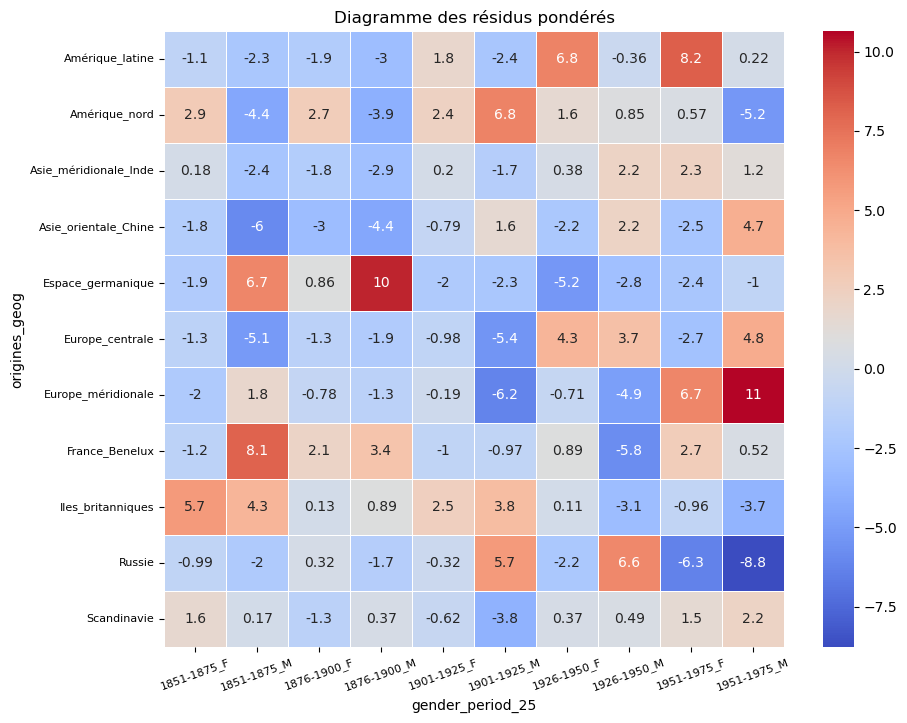

In [403]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(10,8))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, 
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=20, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=0, fontsize=8)


g.set_title('Diagramme des résidus pondérés')

plt.savefig('images/genre_periode_aire_resid_ponderes.jpg', bbox_inches='tight')
plt.show()


In [404]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['1851-1875_F', '1851-1875_M', '1876-1900_F', '1876-1900_M',
       '1901-1925_F', '1901-1925_M', '1926-1950_F', '1926-1950_M',
       '1951-1975_F', '1951-1975_M'],
      dtype='object', name='gender_period_25'),
   row_labels=Index(['Amérique_latine', 'Amérique_nord', 'Asie_méridionale_Inde',
       'Asie_orientale_Chine', 'Espace_germanique', 'Europe_centrale',
       'Europe_méridionale', 'France_Benelux', 'Iles_britanniques', 'Russie',
       'Scandinavie'],
      dtype='object', name='origines_geog'))

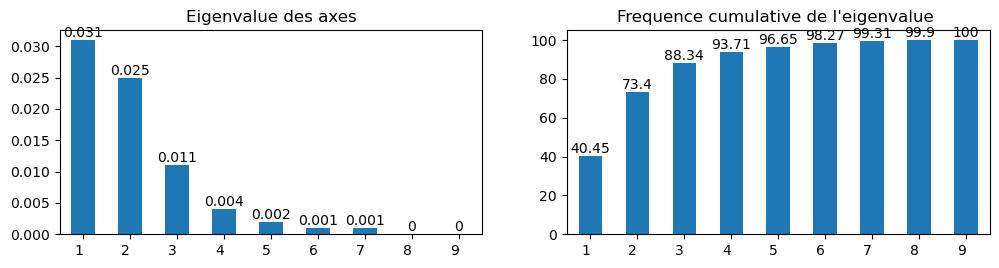

In [405]:
eig = pd.DataFrame(afc.eig_)

r1 = round(eig.iloc[0], 3)
r2 = round(eig.iloc[2], 2)
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])


# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Graphiques et interprétation du premier plan factoriel

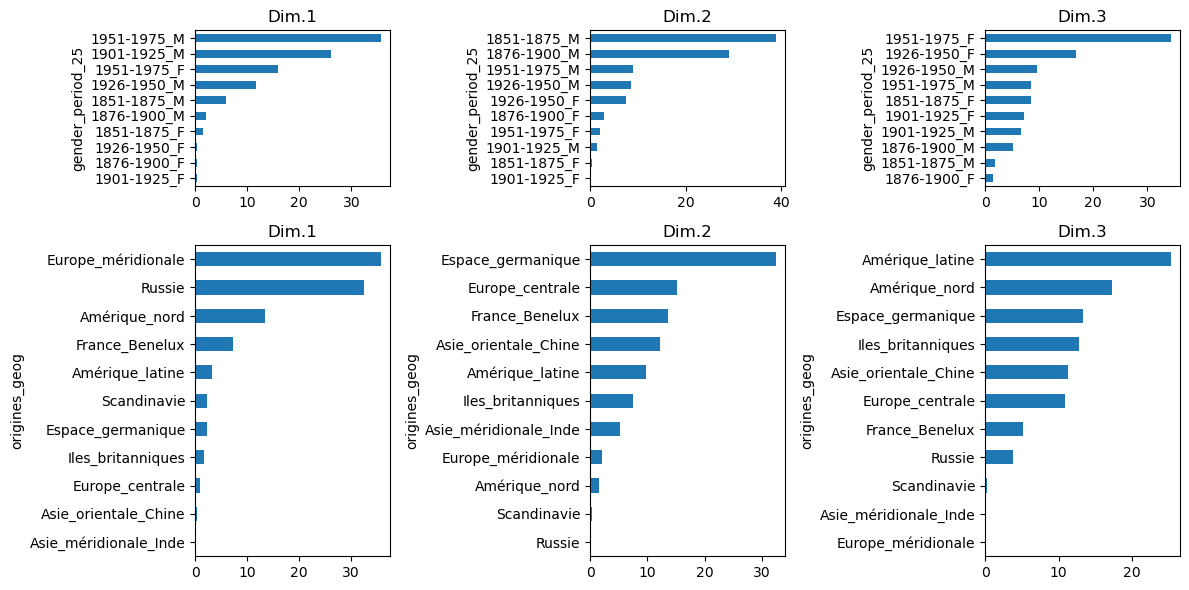

In [406]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6),
                          gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


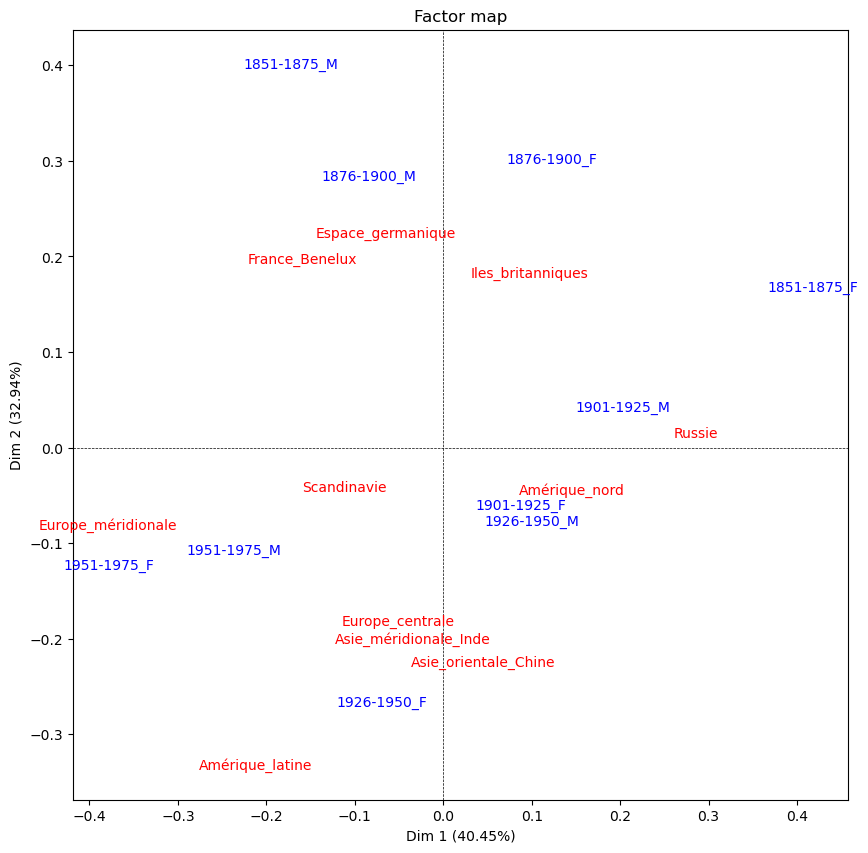

In [408]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))

### Représenter l'autre plan factoriel

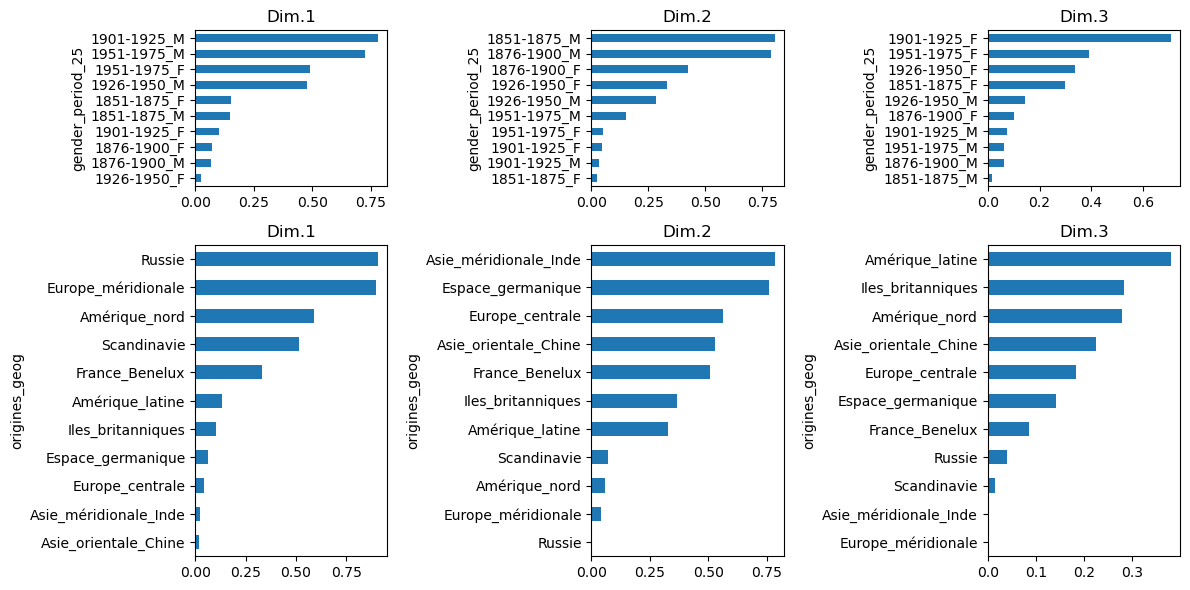

In [409]:
### Informations sur les cosinus carrés. Ces valeurs expriment 
# la qualité de représentation d'une modalité sur l'axe correspondant

### Colonnes
df = afc.col_topandas()[['col_cos2_dim1',
                         'col_cos2_dim2',
                         'col_cos2_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), 
                         gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Lignes
df = afc.row_topandas()[['row_cos2_dim1',
                         'row_cos2_dim2',
                         'row_cos2_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


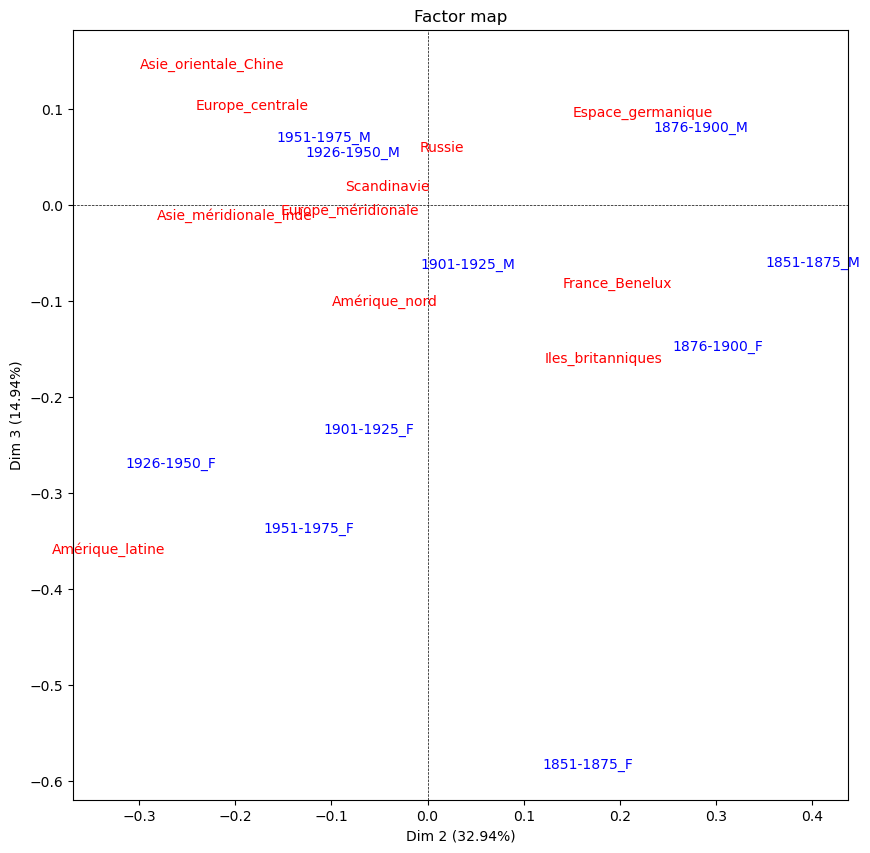

In [410]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(10,10))

### Commentaire

Cette analyse factorielle met en évidence, en relation avec le diagramme des résidus pondérés qui permet de la contrôler, les moments de présence féminine significative dans les générations présentes dans les  différentes régions géoraphiques